# COVID19 - Brazil States

# import Ray

In [61]:
from environs import Env
env = Env()
env.str("CUDA_DEVICE_ORDER",'PCI_BUS_ID')
env.int("CUDA_VISIBLE_DEVICES",512)
env.int("NUMBA_ENABLE_CUDASIM",1)
env.bool("OMPI_MCA_opal_cuda_support",True)

import os
import ray
MB=1024*1024
GB=MB*1024
ray.shutdown()
ray.init(object_store_memory=1*GB,memory=1*GB,lru_evict=True,\
         driver_object_store_memory=500*MB,num_gpus=256,num_cpus=2, ignore_reinit_error=True) # , include_webui=False, ignore_reinit_error=True)

# ray.init(lru_evict=True,object_store_memory=2*GB,memory=4*GB,
#          num_gpus=312,num_cpus=10, include_webui=False, ignore_reinit_error=True)

# ray.shutdown()
# ray.init(num_cpus=10,num_gpus=None)

@ray.remote(num_gpus=1)
def use_gpu():
    print("ray.get_gpu_ids(): {}".format(ray.get_gpu_ids()[0]))
    print("CUDA_VISIBLE_DEVICES: {}".format(os.environ["CUDA_VISIBLE_DEVICES"]))

use_gpu.remote()

[autoreload of LearnerYabox_v2b failed: Traceback (most recent call last):
  File "/home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/home/ats4i/anaconda3/envs/geo_env/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/home/ats4i/anaconda3/envs/geo_env/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _cal

ObjectID(876814b884fba94dffffffff010000c801000000)

# Import Modules

In [62]:
import urllib.request
import pandas as pd
import numpy as np
from datetime import datetime,timedelta

# Download data

In [63]:
import get_data
LoadData=True

if LoadData:
    get_data.get_data()

Baixando arquivos brasil.io...
(pid=108299) ray.get_gpu_ids(): 255
(pid=108299) CUDA_VISIBLE_DEVICES: 255


In [64]:
df = pd.read_csv("data/dados_total_estados.csv")
df.drop('index', axis=1, inplace=True)
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d') 
df = df[df.date<=datetime.strptime("2020-07-02", '%Y-%m-%d')]
display(df)

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,popEst,city_ibge_code,confirmed_per_100k_inhabitants,death_rate
4,2020-07-02,AP,TOTAL,state,29153,427,104,False,845731.0,16.0,3447.07714,0.0146
5,2020-07-01,AP,TOTAL,state,28927,420,103,False,845731.0,16.0,3420.35470,0.0145
6,2020-06-30,AP,TOTAL,state,28492,417,102,False,845731.0,16.0,3368.91990,0.0146
7,2020-06-29,AP,TOTAL,state,28253,413,101,False,845731.0,16.0,3340.66033,0.0146
8,2020-06-28,AP,TOTAL,state,27985,407,100,False,845731.0,16.0,3308.97177,0.0145
...,...,...,...,...,...,...,...,...,...,...,...,...
3057,2020-02-29,SP,TOTAL,state,2,0,5,False,45919049.0,35.0,0.00436,0.0000
3058,2020-02-28,SP,TOTAL,state,2,0,4,False,45919049.0,35.0,0.00436,0.0000
3059,2020-02-27,SP,TOTAL,state,1,0,3,False,45919049.0,35.0,0.00218,0.0000
3060,2020-02-26,SP,TOTAL,state,1,0,2,False,45919049.0,35.0,0.00218,0.0000


# Model

# SEAIR-D Model Equations

$$\begin{array}{l}\frac{d s}{d t}=-[\beta i(t) + \beta_2 a(t)-\mu] \cdot s(t)\\ 
\frac{d e}{d t}=[\beta i(t) + \beta_2 a(t)] \cdot s(t) -(\sigma+\mu) \cdot e(t)\\ 
\frac{d a}{d t}=\sigma e(t) \cdot (1-p)-(\gamma_2+\mu) \cdot a(t) \\
\frac{d i}{d t}=\sigma e(t) \cdot p - (\gamma + \sigma_2 + \sigma_3 + \mu) \cdot i(t)\\ 
\frac{d r}{d t}=(b + \sigma_2) \cdot i(t) + d \cdot a(t) - \mu \cdot r(t)\\
\frac{d k}{d t}=(a + \sigma_3 - \mu) \cdot d(t) + c \cdot a(t)
\end{array}$$

$$\gamma = a + b$$

$$\gamma_2 = c + d$$

$$p=0.2$$

The last equation does not need to be solve because:

$$s + e + i + a + r + k = N$$ 

$N$ is the total population of the region, state or country. If you derivate and by considering population constant during the period of simulation, you get the equation of $k$ without depending of the $N$.

$$\frac{d k}{d t}=-(\frac{d e}{d t}+\frac{d a}{d t}+\frac{d i}{d t}+\frac{d r}{d t})$$

The sum of all rates are equal to zero! The importance of this equation is that it conservates the rates.

## Parameters

$\beta$: Effective contact rate [1/min]
    
$\gamma$: from infected Recovery(+Mortality) rate $\gamma=(a+b)$ [1/min]

$\gamma_2$: from assymptomatic Recovery(+Mortality) rate $\gamma=(a+b)$ [1/min]

$a$: mortality of healed from infected  [1/min]

$b$: recovery rate from infected [1/min]

$c$: mortality of healed from assymptomatic [1/min]

$d$: recovery rate from assymptomatic [1/min]

$\sigma$: is the rate at which individuals move from the exposed to the infectious classes. Its reciprocal ($1/\sigma$) is the average latent (exposed) period.

$\sigma_2$: is the rate at which individuals move from the infectious to the healed classes. Its reciprocal ($1/\sigma_2$) is the average latent (exposed) period

$\sigma_3$: is the rate at which individuals move from the infectious to the dead classes. Its reciprocal ($1/\sigma_3$) is the average latent (exposed) period
    
$p$: is the fraction of the exposed which become symptomatic infectious sub-population.

$(1-p)$: is the fraction of the exposed which becomes asymptomatic infectious sub-population.

# Initial parameters

In [65]:
paramOpt=4
changeCSV=False
adjustParam=True
paramSave=False
selectStates=False

## Select Parameters File, Version and Model

In [66]:
if paramOpt==0:
    paramFile="data/param.csv"
    version = "1"
    model = "ManualIC"

if paramOpt==1:
    paramFile="data/param_optimized_DE_Scipy.csv"    
    version = "1002"
    model = "DE_ScipyIC"
    
if paramOpt==2:
    paramFile="data/param_optimized_DE_SciPy_HistMin.csv"
    version = "1002"
    model = "DE_ScipyIC"

if paramOpt==3:
    paramFile="data/param_optimized_Yabox.csv"    
    version = "103"
    model = "YaboxIC"
    
if paramOpt==4:
    paramFile="data/param_optimized_Yabox_HistMin.csv"
    version = "103"
    model = "YaboxIC"

if paramOpt==5:
    paramFile="data/param_optimized_Brute_Force.csv"
    version = "12"
    model = "BruteForceIC"

if paramOpt==6:
    paramFile="data/param_optimized_Brute_Force_HistMin.csv"
    version = "12"
    model = "BruteForceIC"

## Final Adjust in Parameters

In [67]:
dfparam = pd.read_csv(paramFile)
dfparam = dfparam.dropna()

if selectStates:
    states=['SP','MG','AM','PE','ES','RJ']
else:
    states=dfparam.state

if changeCSV:
    dfparam.loc[dfparam.state=='PI','d0'] = 0
    dfparam.loc[dfparam.state=='RR','d0'] = 0
    dfparam.loc[dfparam.state=='AP','d0'] = 0
    dfparam.loc[dfparam.state=='SP','WCASES'] = 0.65

if paramSave:
    dfparam.to_csv(paramFile)    
    
if adjustParam:
    sCorrect=[1.25,1.3,1.3,1.3,1.3,1.3,1.3,1.3,1.0,1.0,1.1]
    dfparam.s0=dfparam.s0.multiply(sCorrect[:len(states)], axis=0)

dfparam

,state,start-date,prediction-range,s0,e0,a0,i0,r0,d0,START,RATIO,WCASES,WREC
0,SP,2020-03-15,200,1.141715e+07,0,0,713,300,250,100,0.15,0.438537,0.004821
1,ES,2020-04-01,200,7.193949e+05,0,0,55,250,50,100,0.15,0.446217,0.019239
2,MG,2020-04-01,200,1.590210e+06,0,0,223,250,40,100,0.15,0.301378,0.009798
3,RJ,2020-03-20,200,1.036969e+06,0,0,830,250,50,100,0.15,0.666680,0.031825
4,CE,2020-03-20,200,8.770345e+05,0,0,739,250,50,100,0.15,0.552314,0.022969
5,PE,2020-03-20,200,1.072648e+06,0,0,667,250,100,100,0.15,0.435306,0.018729
6,AM,2020-03-20,200,1.031154e+06,0,0,737,250,100,100,0.15,0.582615,0.003338
7,PA,2020-03-20,200,1.014930e+06,0,0,902,250,100,100,0.15,0.530999,0.034237
8,PI,2020-03-20,200,8.251397e+05,0,0,940,250,100,100,0.15,0.318747,0.028869
9,RR,2020-03-20,200,8.086198e+05,0,0,769,250,100,100,0.15,0.392673,0.039875


# Define States Array and Import Solver

In [68]:
# Load solver
%reload_ext autoreload
%autoreload 2
import LearnerYabox_v2b as Learner #Yabox

## Activate Scrolling

In [69]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return true;}

<IPython.core.display.Javascript object>

## Select the Running Type

In [70]:
allStates=False
cleanRecovered=False
version="8"

## Main Loop

In [71]:
results=[]
if allStates:
    for state in states:        
        query = dfparam.query('state == "{}"'.format(state)).reset_index()
        parameters = np.array(query.iloc[:, 2:])[0]
        f=Learner.Learner.remote(state, *parameters, cleanRecovered, version)
        result = f.train.remote() 
        results.append(result)
else:
    state= "RJ"
    query = dfparam.query('state == "{}"'.format(state)).reset_index()
    parameters = np.array(query.iloc[:, 2:])[0]
    parameters
    cleanRecovered = False
    f=Learner.Learner.remote(state, *parameters, cleanRecovered, version)
    result = f.train.remote() 
    results.append(result)

# #execute all the queue with max_runner_cap at a time    
results = ray.get(results)

  0%|          | 9870/6125000 [01:50<10:26:41, 162.63it/s]


  1%|          | 39060/6125000 [03:35<4:23:58, 384.26it/s]


  1%|▏         | 87571/6125000 [05:10<2:40:06, 628.47it/s]


  3%|▎         | 154846/6125000 [06:46<2:01:18, 820.29it/s]


  4%|▍         | 240471/6125000 [08:18<1:26:04, 1139.44it/s]


  6%|▌         | 343206/6125000 [09:37<1:07:22, 1430.30it/s]


  8%|▊         | 464166/6125000 [11:00<59:03, 1597.33it/s]


 10%|▉         | 607753/6125000 [12:28<51:37, 1781.39it/s]


 13%|█▎        | 770661/6125000 [13:54<45:10, 1975.33it/s]


 16%|█▌        | 952890/6125000 [15:25<45:38, 1888.75it/s]


 19%|█▉        | 1151403/6125000 [16:54<34:57, 2370.95it/s]


 22%|██▏       | 1368685/6125000 [18:23<30:54, 2564.37it/s]


 26%|██▌       | 1604736/6125000 [19:54<25:51, 2914.16it/s]


 30%|███       | 1859556/6125000 [21:19<22:30, 3157.57it/s]


 35%|███▍      | 2133145/6125000 [22:51<20:12, 3293.30it/s]


 40%|███▉      | 2425503/6125000 [24:18<18:20, 3360.67it/s]


 45%|████▍     | 2736630/6125000 [25:57<16:06, 3504.86it/s]


 46%|████▌     | 2826253/6125000 [26:22<14:47, 3715.45it/s]
(pid=108299) /home/ats4i/anaconda3/envs/geo_env/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
(pid=108299)   warnings.warn(warning_msg, ODEintWarning)
 50%|████▉     | 3054156/6125000 [27:22<13:26, 3805.98it/s]


 56%|█████▌    | 3402136/6125000 [28:59<10:53, 4168.04it/s]


 62%|██████▏   | 3768885/6125000 [30:27<09:33, 4108.01it/s]


 68%|██████▊   | 4154403/6125000 [32:03<07:19, 4484.00it/s]


 74%|███████▍  | 4558690/6125000 [33:36<05:12, 5011.37it/s]


 81%|████████▏ | 4981746/6125000 [35:11<03:49, 4980.58it/s]


 89%|████████▊ | 5423571/6125000 [36:37<02:17, 5084.28it/s]


 96%|█████████▌| 5884165/6125000 [38:14<00:46, 5213.67it/s]


100%|█████████▉| 6123250/6125000 [38:59<00:00, 2617.04it/s]


In [72]:
ray.shutdown()

# Plots

In [73]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import covid_plots

In [74]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines){
    return false;}

<IPython.core.display.Javascript object>

In [75]:
#select districts for plotting log plot
states4Plot=['MG',
               'SP',
               'ES',
               'CE',
               'RJ']

#Choose here your options
#opt=0 all plots
#opt=1 corona log plot
#opt=2 logistic model prediction
#opt=3 bar plot with growth rate
#opt=4 log plot + bar plot
#opt=5 SEAIR-D Model
opt = 5

#number of cases to start plotting model in log graph - real data = 100
startCase=100

In [76]:
#plots one district or all districts
plotStates=True

#select states for plotting
#you need to run (solve) it before plotting
if plotStates:
    states=dfparam.state
    allStates=True

#main state for plotting log graph or SEAIRD plot
state="SP"

#if it is not SEAIRD plot, so plot one state only
if not opt==5:
    AllStates=False

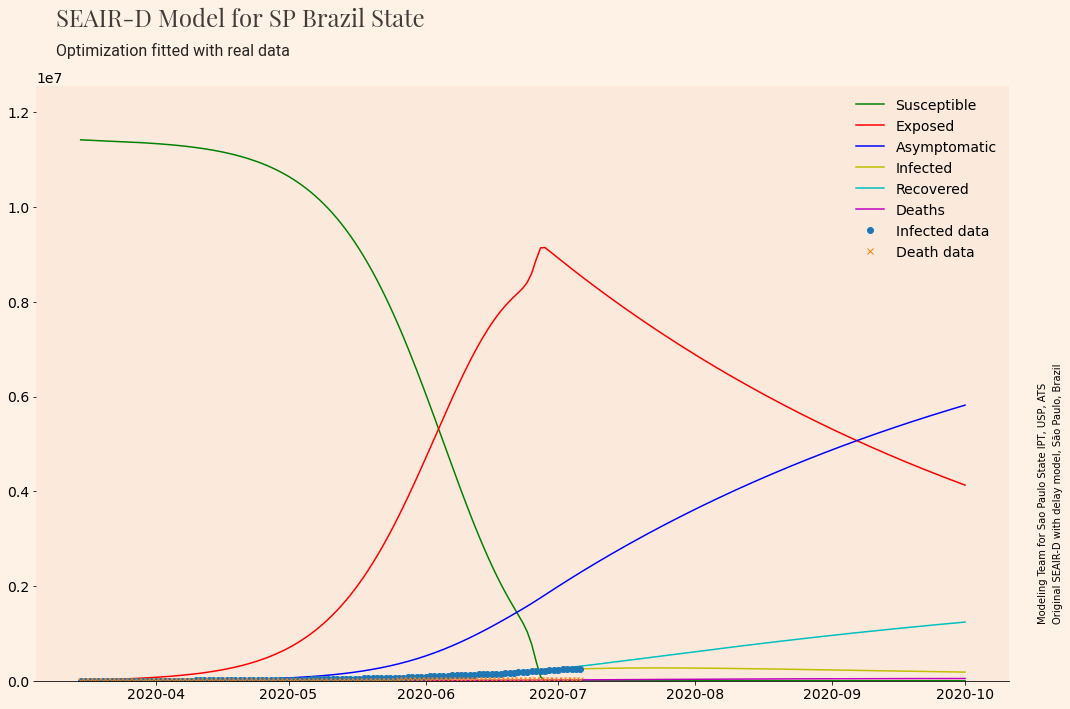

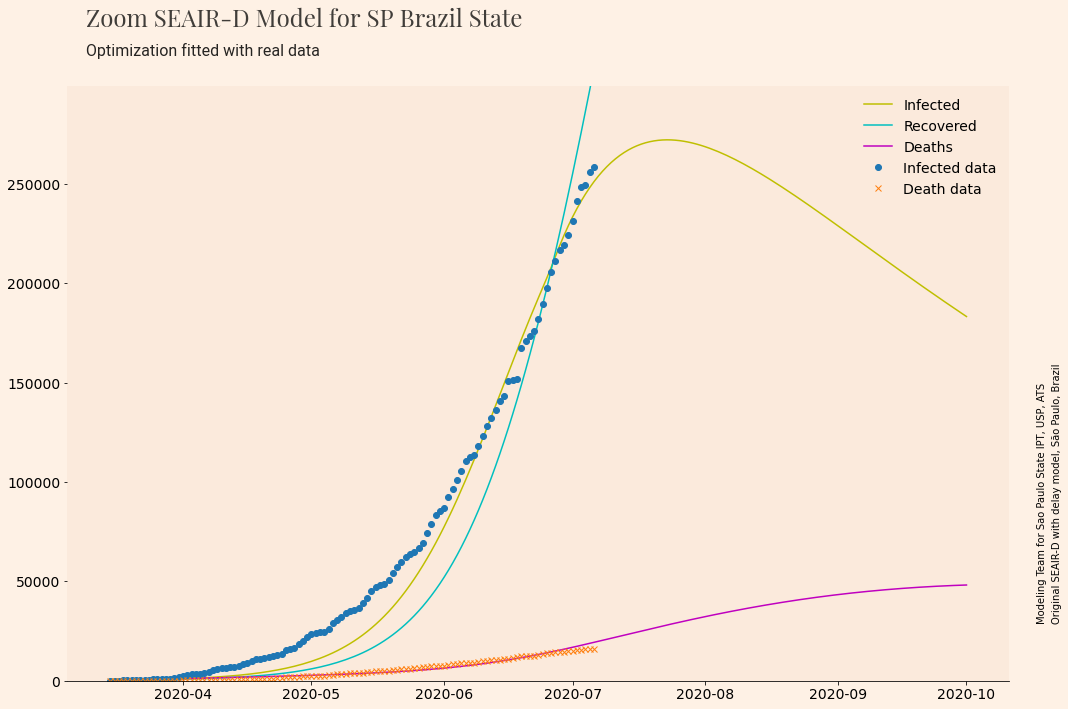

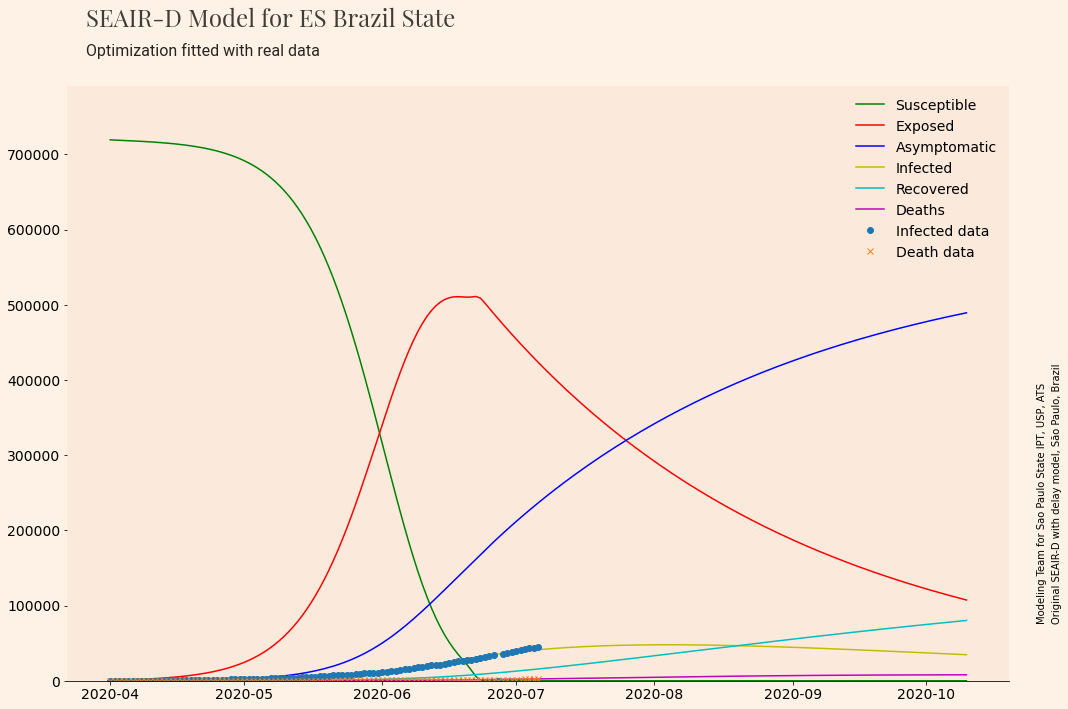

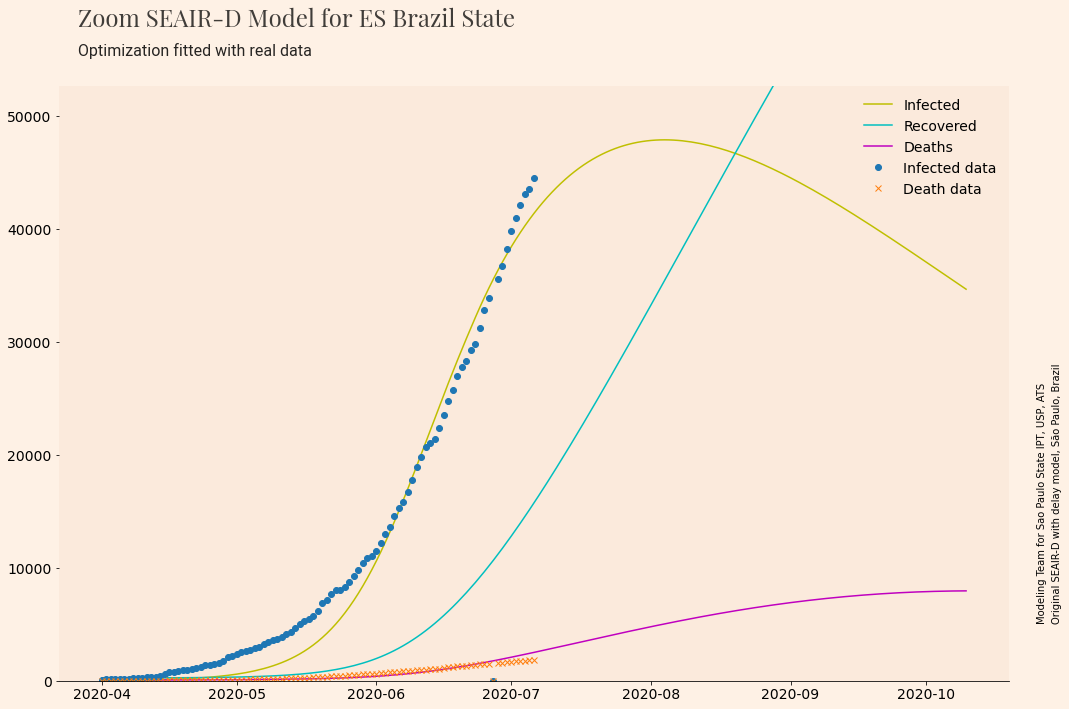

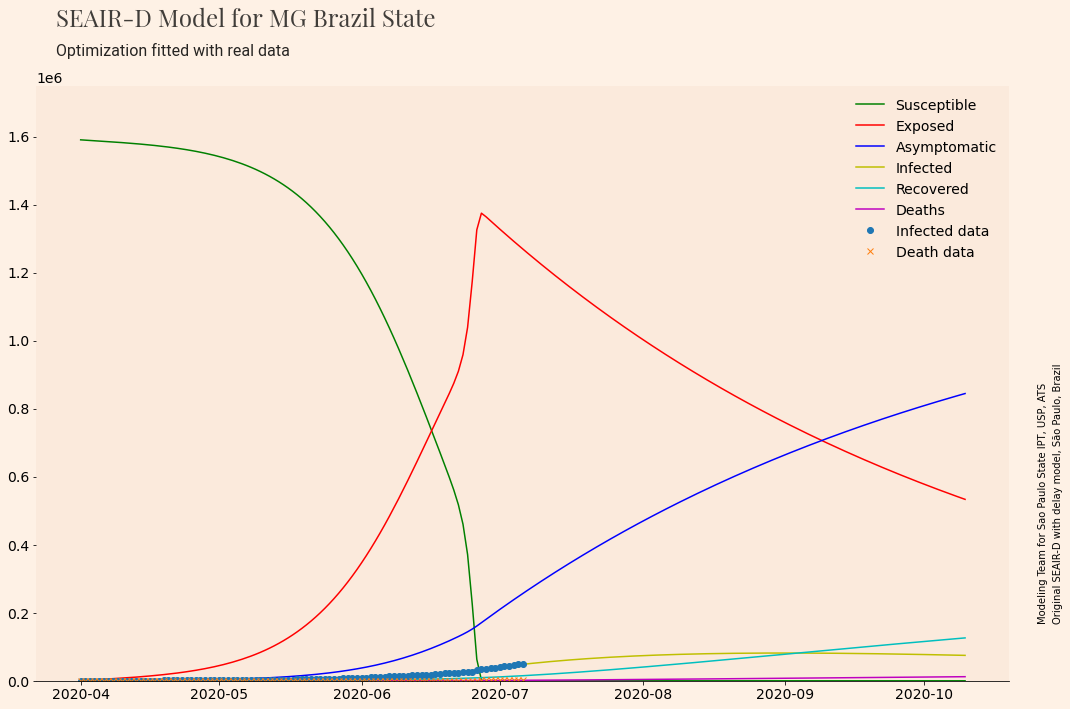

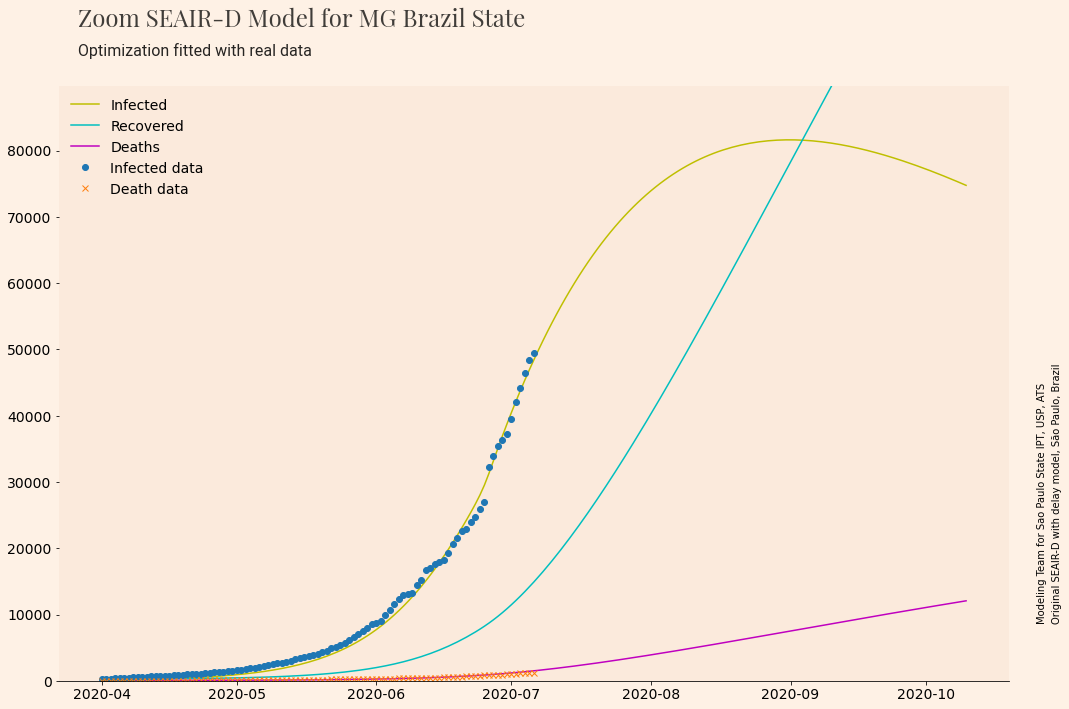

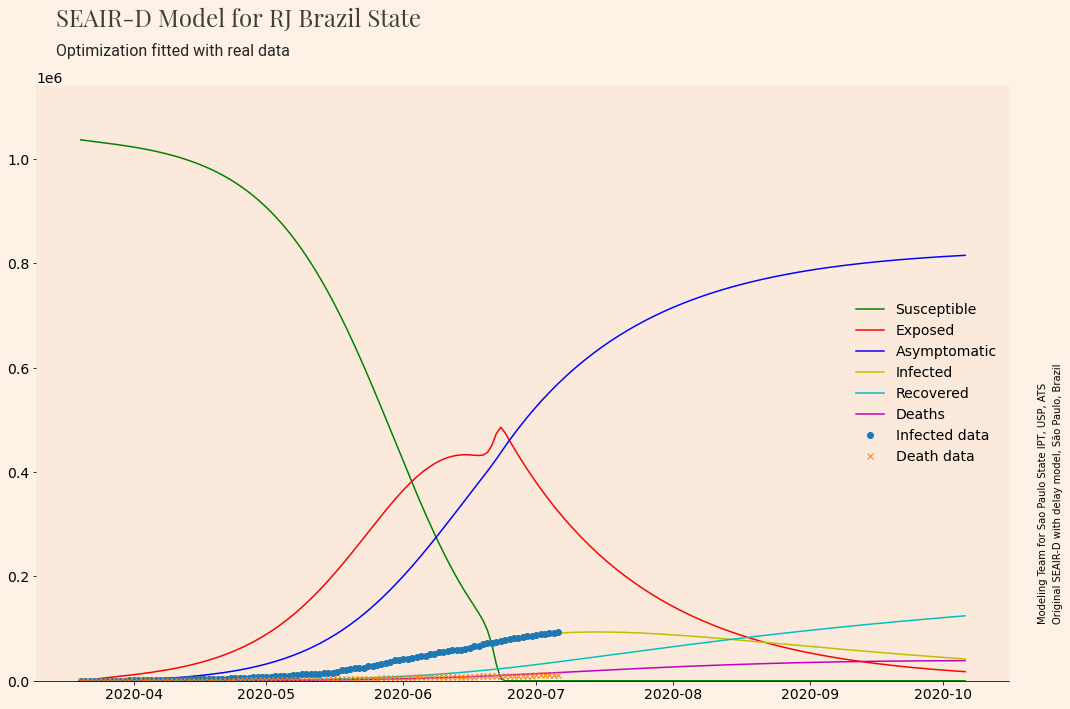

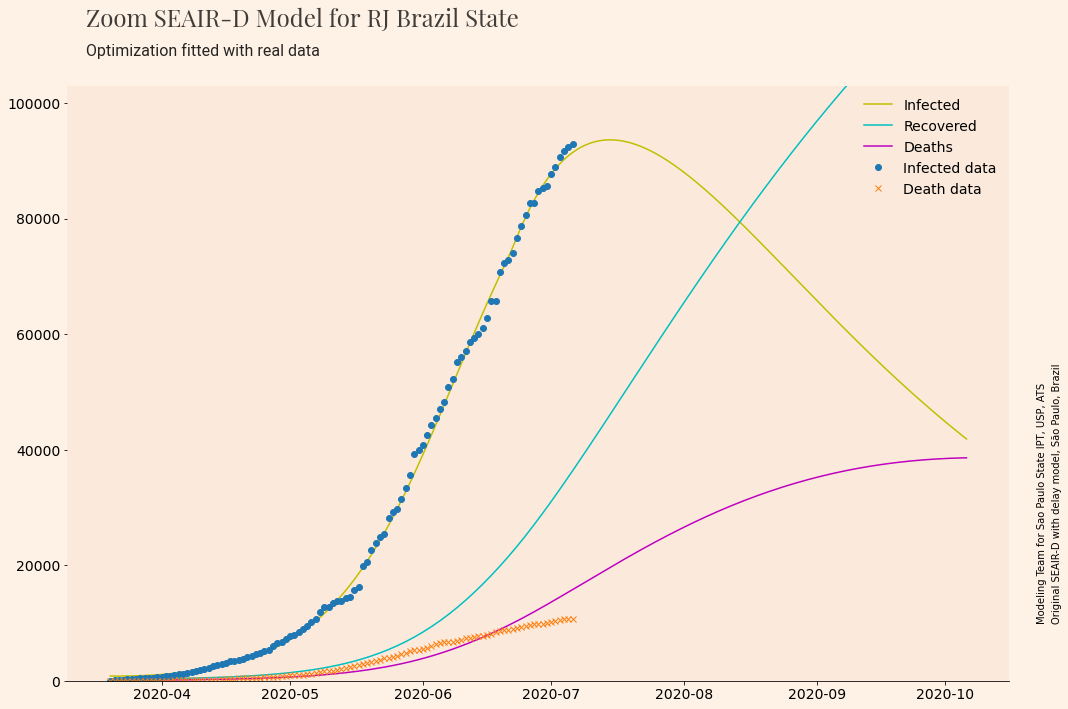

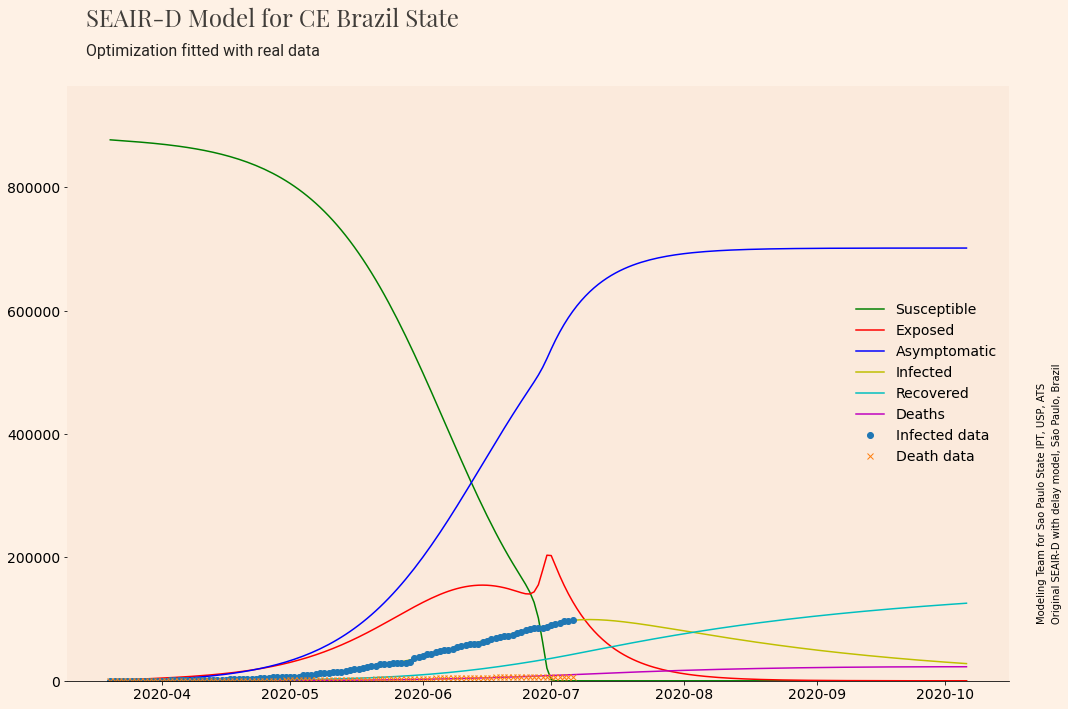

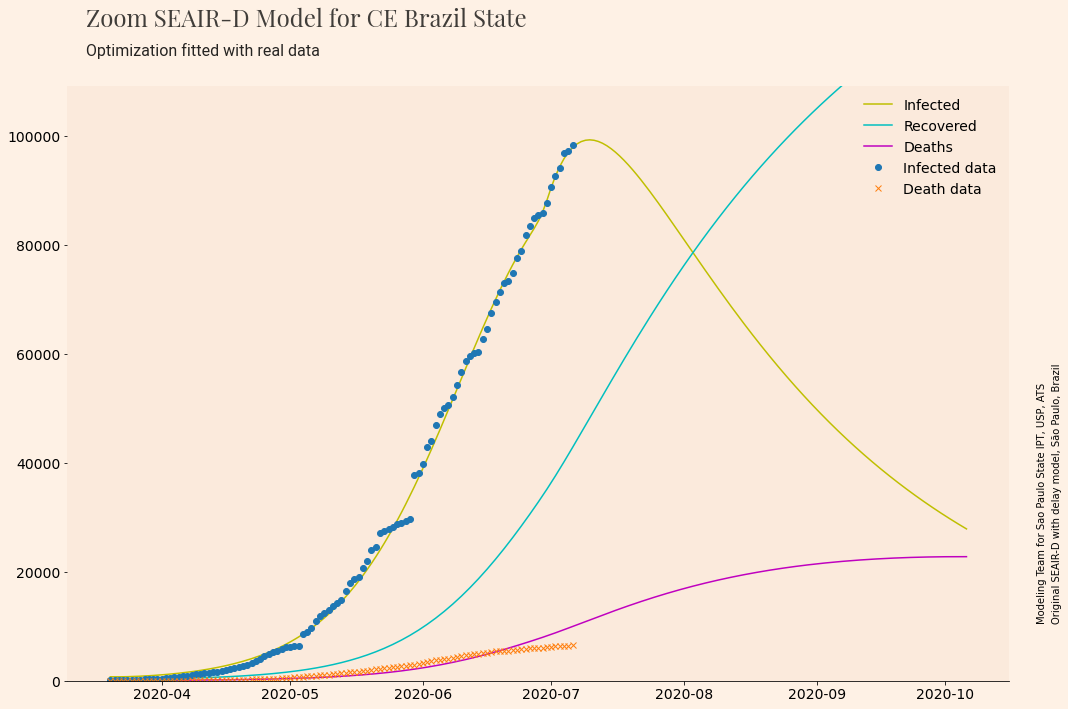

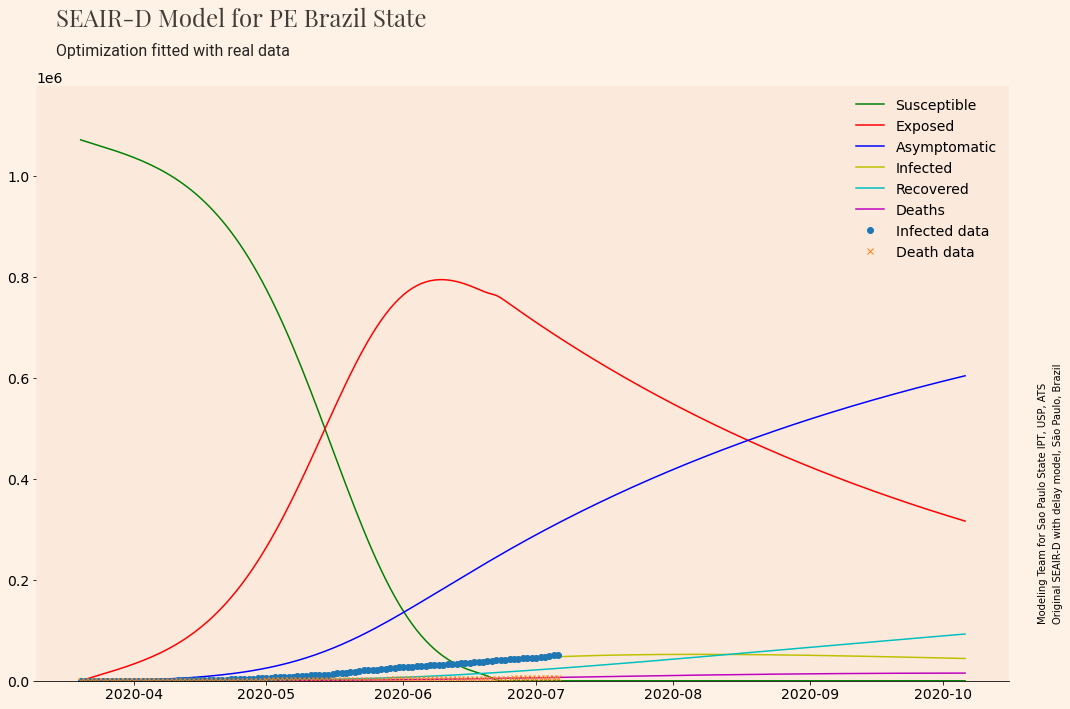

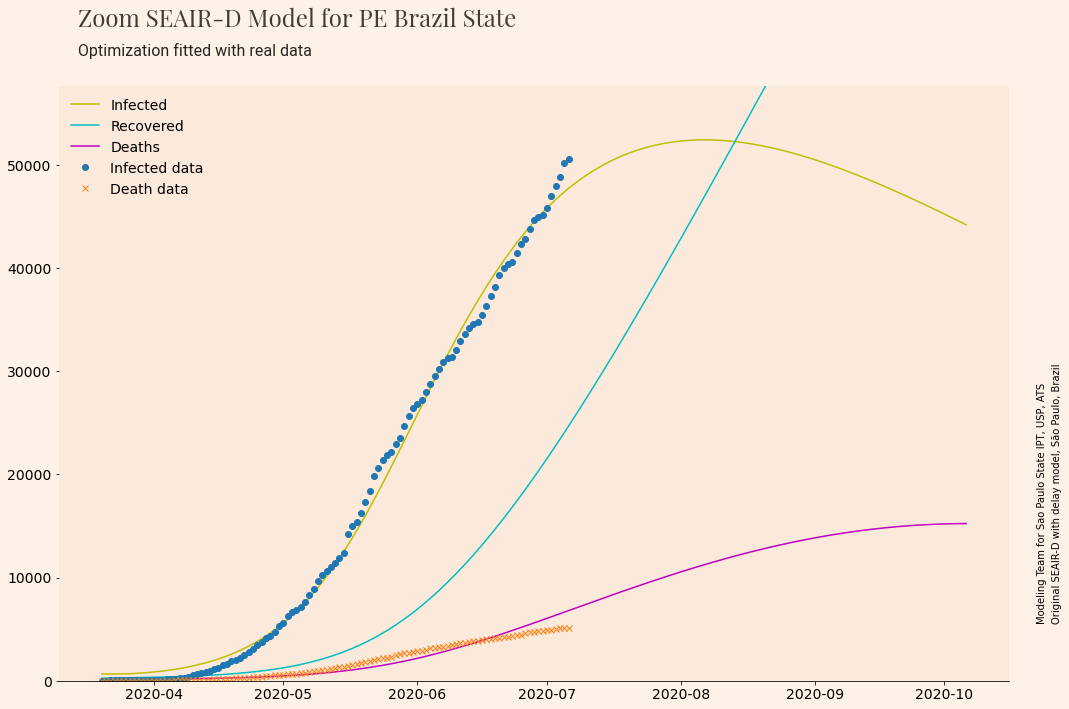

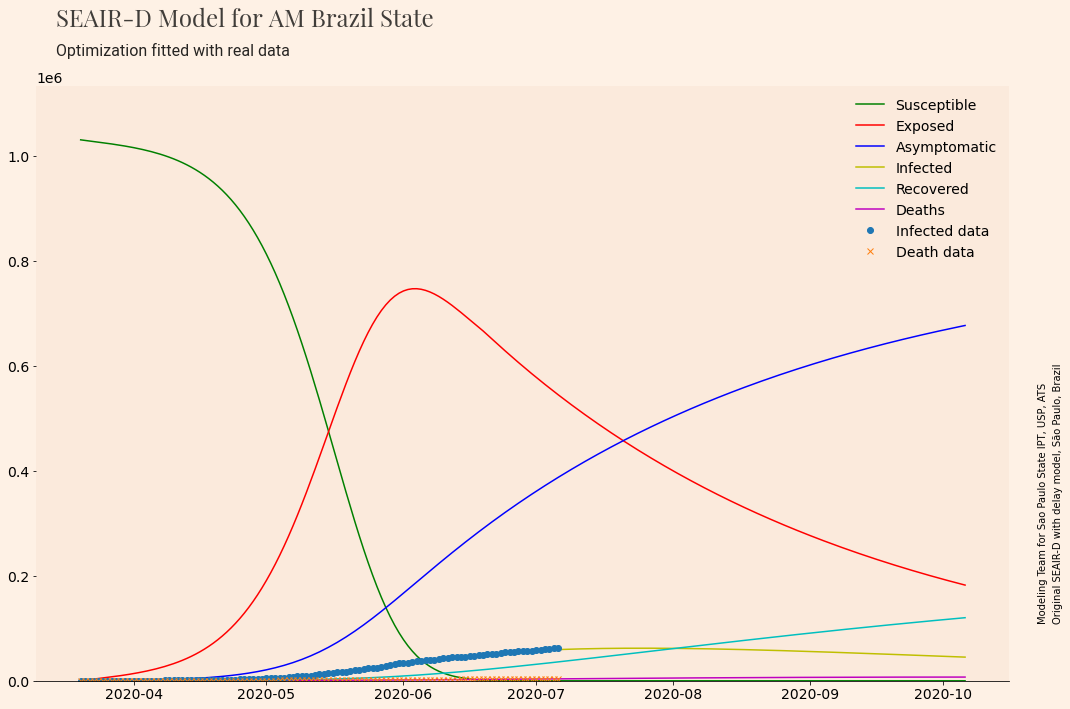

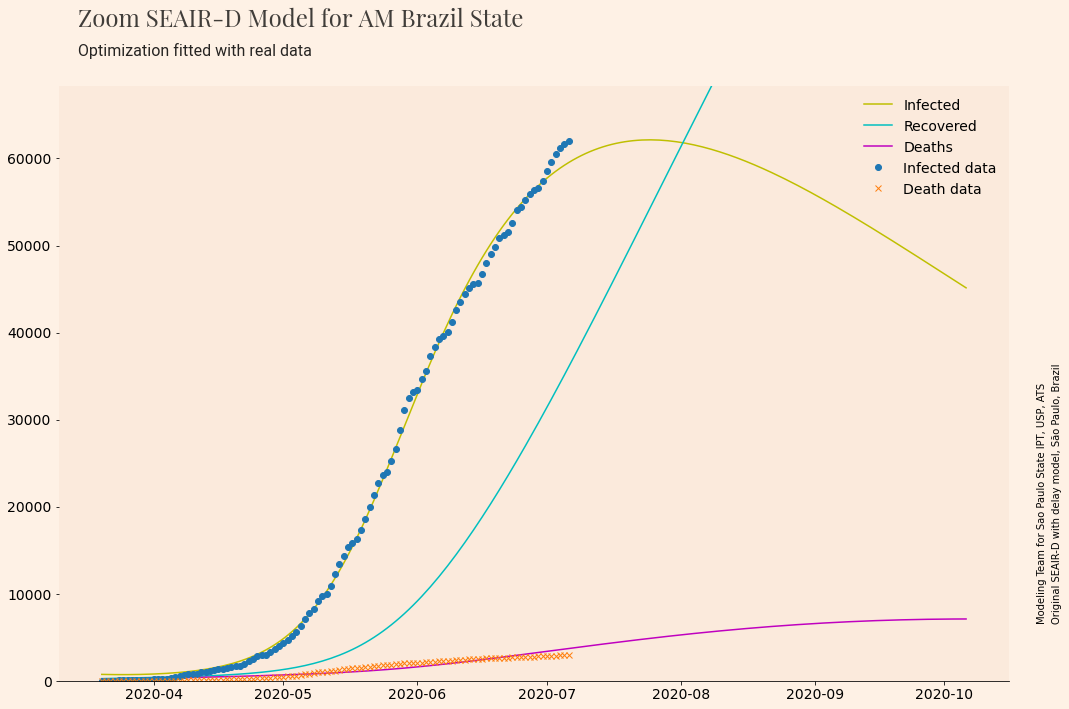

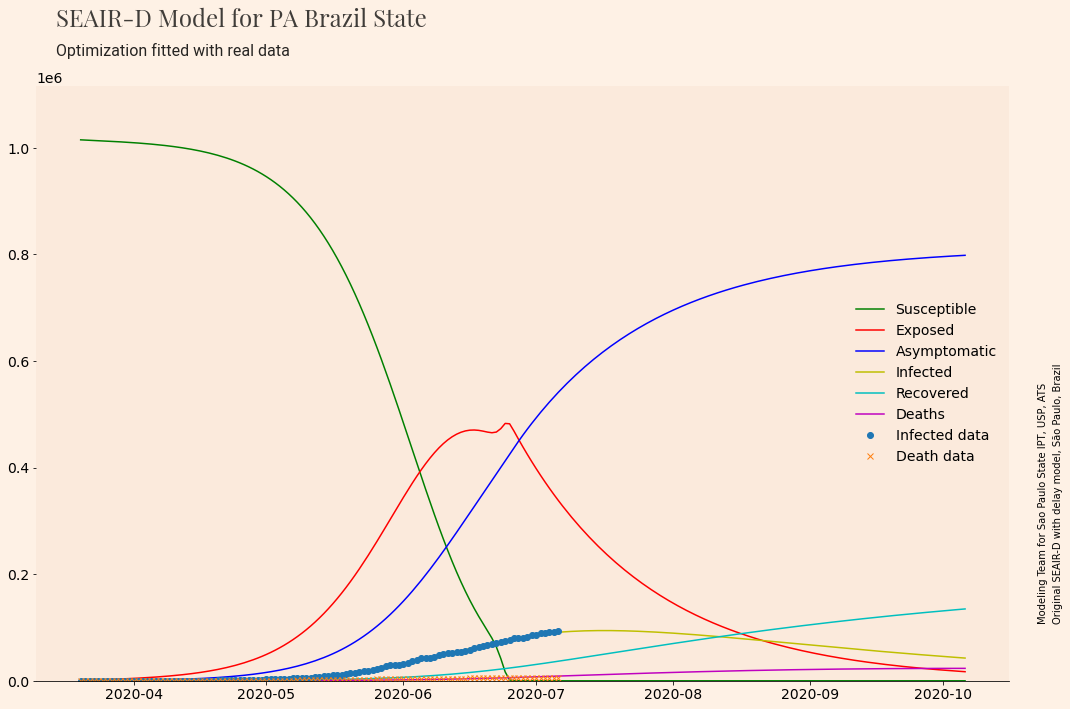

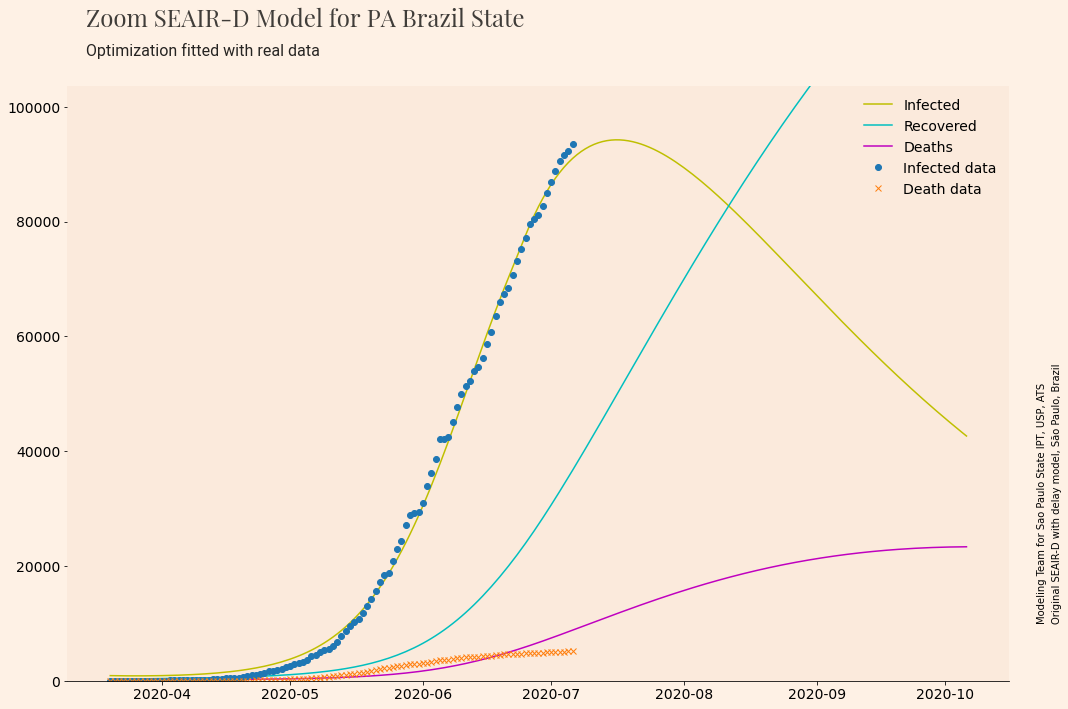

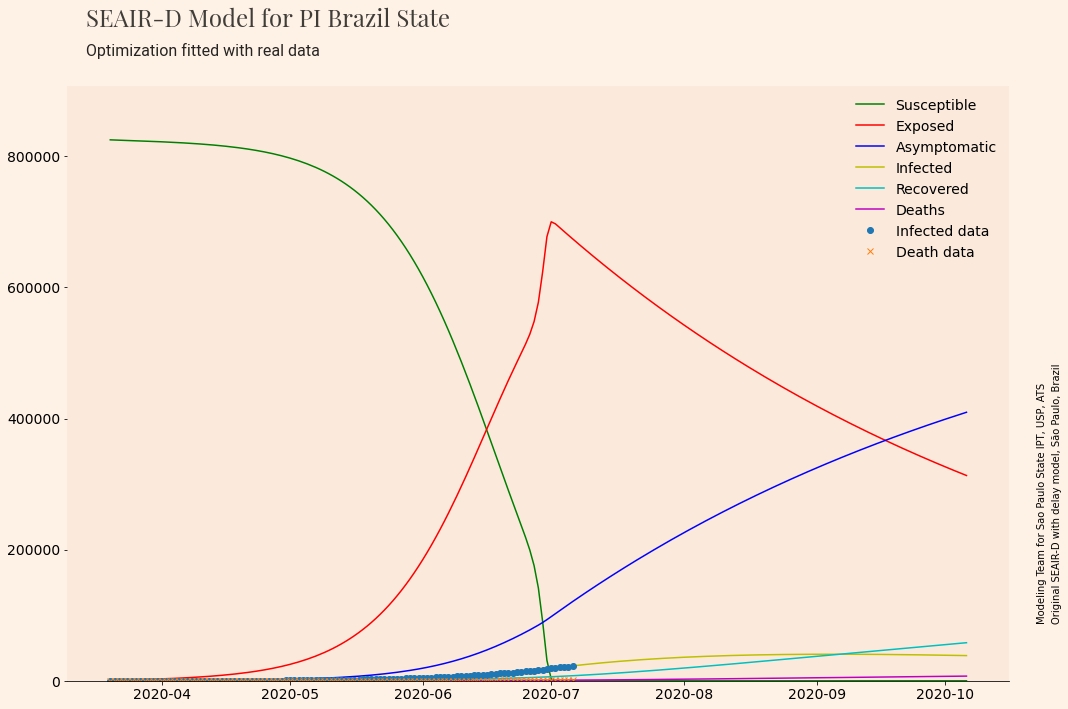

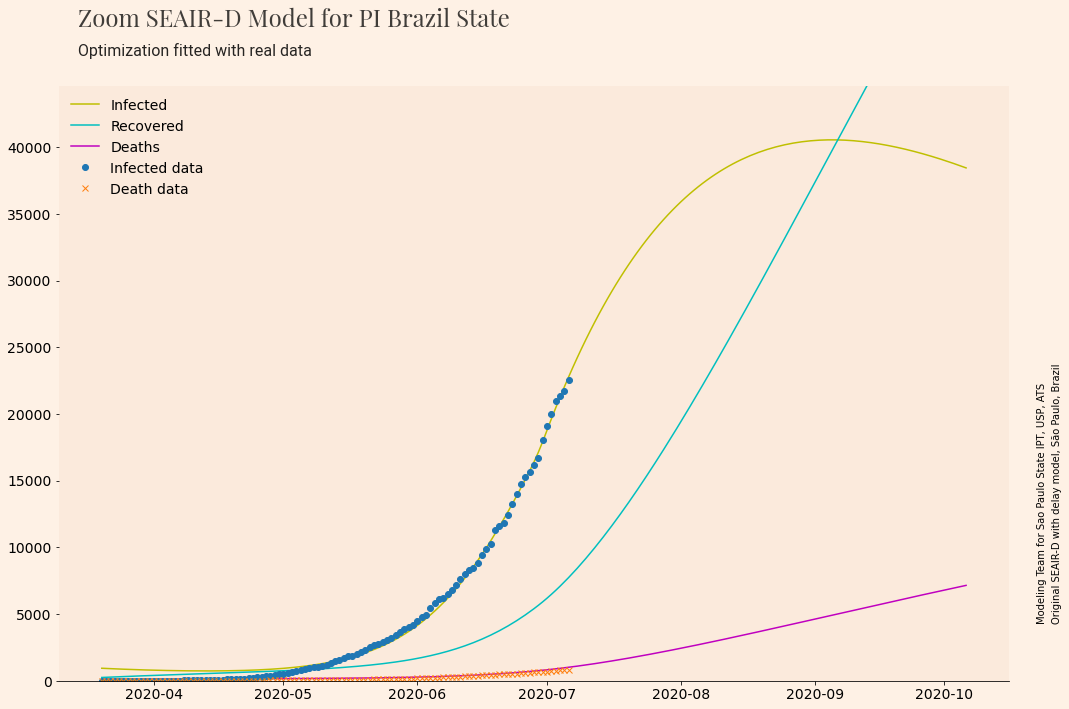

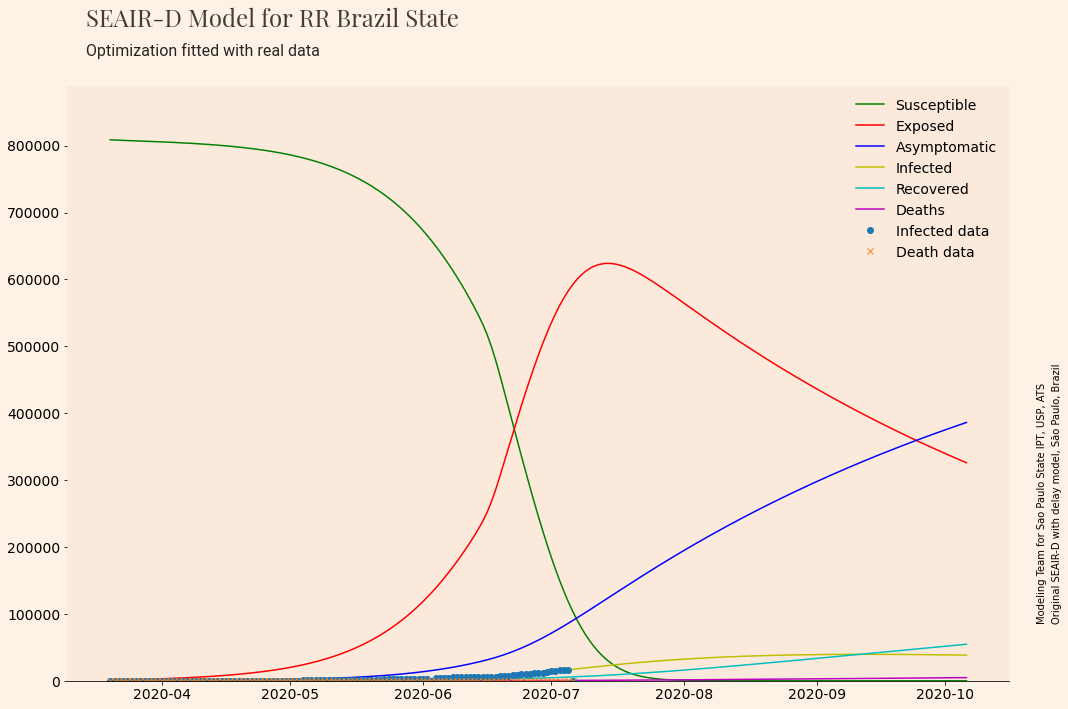

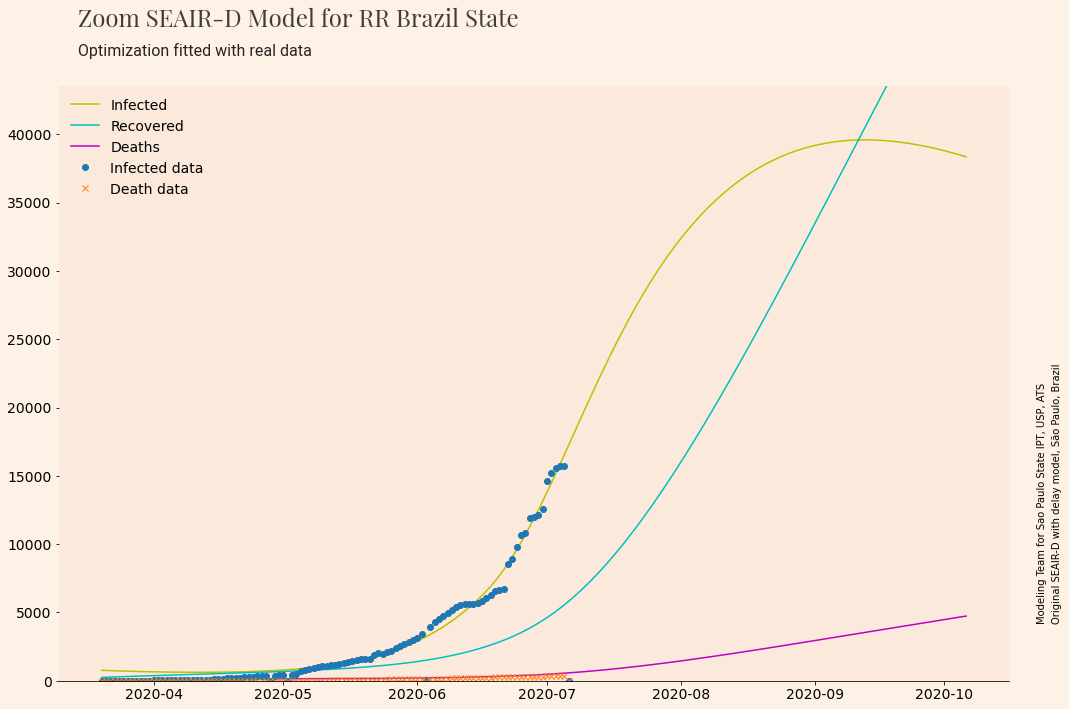

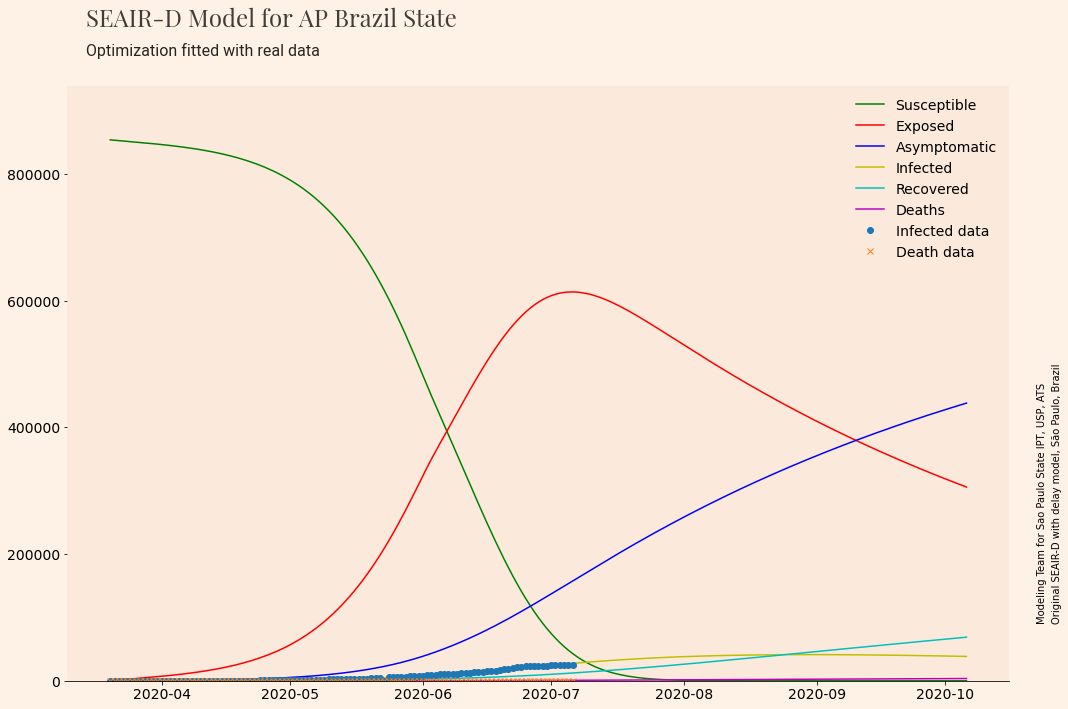

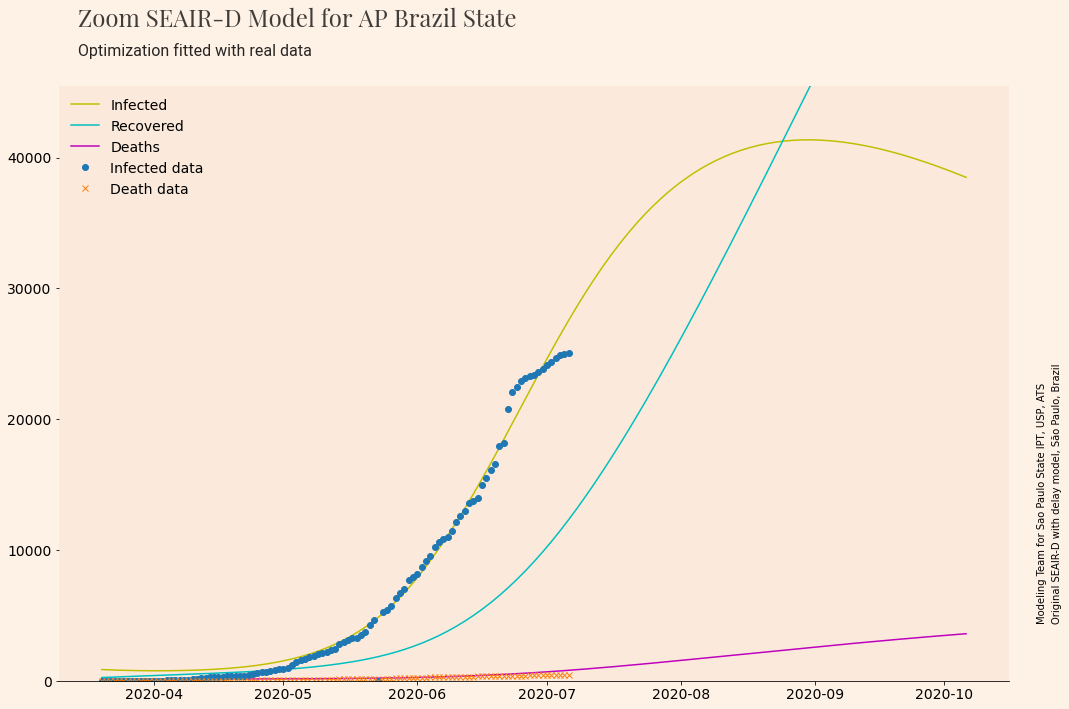

In [77]:
if allStates:
    for state in states:
        query = dfparam.query('state == "{}"'.format(state)).reset_index()
        ratio = query['RATIO'][0]
        startCase = query['START'][0]
        startdate = query['start-date'][0]
        predict_range = query['prediction-range'][0]
        
        #calcula data máxima dos gráficos
        #100 dias é usado como máximo dos cálculos da derivada das mortes
        lastDate=df.date.max()
        maxDate= lastDate + timedelta(days = 100) #"2020-08-31"
        maxDateStr = maxDate.strftime("%Y-%m-%d")

        covid_plots.covid_plots(state, states4Plot, startdate, predict_range, \
                        startCase, 5, version, show=True, ratio=ratio, maxDate=maxDateStr, model=model)
else: 
    query = dfparam.query('state == "{}"'.format(state)).reset_index()
    ratio = query['RATIO'][0]
    startdate = query['start-date'][0]
    predict_range = query['prediction-range'][0]
    startCase = query['START'][0]
    
    #calcula data máxima dos gráficos
    #100 dias é usado como máximo dos cálculos da derivada das mortes
    lastDate=df.date.max()
    maxDate= lastDate + timedelta(days = 100) #"2020-08-31"
    maxDateStr = maxDate.strftime("%Y-%m-%d")    
    
    covid_plots.covid_plots(state, states4Plot, startdate, predict_range, \
                       startCase, opt, version, show=True, ratio=ratio, maxDate=maxDateStr, model=model)